<a href="https://colab.research.google.com/github/lmethratta/Poliscope/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets transformers rank_bm25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import re
from rank_bm25 import BM25Okapi
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, average_precision_score, confusion_matrix
from sklearn.pipeline import Pipeline

In [3]:
# Load dataset
!wget -O data.csv "https://raw.githubusercontent.com/lmethratta/Poliscope/refs/heads/main/twinviews-13k.csv"

# Load CSV into a DataFrame
df = pd.read_csv("data.csv")


--2025-04-24 01:50:27--  https://raw.githubusercontent.com/lmethratta/Poliscope/refs/heads/main/twinviews-13k.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3063233 (2.9M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   2.92M  --.-KB/s    in 0.05s   

2025-04-24 01:50:27 (59.3 MB/s) - ‘data.csv’ saved [3063233/3063233]



In [4]:
# Create a regression dataset with scores from -1 to 1
df_left = df[['l']].rename(columns={'l': 'text'})
df_left['bias_score'] = -1  # Left bias

df_right = df[['r']].rename(columns={'r': 'text'})
df_right['bias_score'] = 1  # Right bias

# Combine datasets and shuffle
df_combined = pd.concat([df_left, df_right]).sample(frac=1).reset_index(drop=True)

# Split into train and validation
train_df, val_df = train_test_split(df_combined, test_size=0.1, random_state=42)

# Load pre-trained tokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
def average_precision_at_k(relevance_scores, k):
    """Computes Average Precision at K"""
    relevance_scores = np.array(relevance_scores)[:k]
    num_relevant = np.sum(relevance_scores)
    if num_relevant == 0:
        return 0.0
    cumulative_precision = [
        np.sum(relevance_scores[:i+1]) / (i+1) for i in range(len(relevance_scores))
    ]
    return np.sum(cumulative_precision * relevance_scores) / num_relevant

def mean_average_precision(relevance_scores_list, k=10):
    """Computes Mean Average Precision (MAP)"""
    return np.mean([average_precision_at_k(scores, k) for scores in relevance_scores_list])

def dcg_at_k(relevance_scores, k):
    """Computes Discounted Cumulative Gain at K"""
    relevance_scores = np.array(relevance_scores)[:k]
    return np.sum(relevance_scores / np.log2(np.arange(2, len(relevance_scores) + 2)))

def ndcg_at_k(relevance_scores, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG)"""
    ideal_relevance = sorted(relevance_scores, reverse=True)  # Ideal DCG
    return dcg_at_k(relevance_scores, k) / (dcg_at_k(ideal_relevance, k) + 1e-10)


In [6]:
# Create torch datasets
class PoliticalBiasDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, tokenizer):
        self.encodings = tokenizer(dataframe["text"].tolist(), padding=True, truncation=True, return_tensors="pt")
        self.labels = torch.tensor(dataframe["bias_score"].values, dtype=torch.float32)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Create datasets
train_dataset = PoliticalBiasDataset(train_df, tokenizer)
val_dataset = PoliticalBiasDataset(val_df, tokenizer)

In [7]:
# Load model for regression (1 output for the bias score)
# API Key: 22837c95f026f63e3b60016c1de298e170d484cd
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the model
trainer.train()

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rombuski (rombuski-northeastern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.093000,0.074156
2,0.002100,0.042445
3,0.002500,0.043047


TrainOutput(global_step=4677, training_loss=0.07025964504459493, metrics={'train_runtime': 594.4004, 'train_samples_per_second': 125.87, 'train_steps_per_second': 7.868, 'total_flos': 832338622379394.0, 'train_loss': 0.07025964504459493, 'epoch': 3.0})

In [24]:
# Function to predict bias score for new text
def predict_bias(text, model, tokenizer, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)

    # Tokenize the input text
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)

    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)

    return outputs.logits.item()

test_texts = [
    "Abortion should be free",
    "Lower taxes and less regulation will stimulate economic growth.",
    "Healthcare should be a basic right for all citizens."
]

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

for text in test_texts:
    score = predict_bias(text, model, tokenizer)
    print(f"Text: {text}")
    print(f"Bias score: {score:.2f}")
    print(f"Political leaning: {'Left' if score < 0 else 'Right'}")
    print("-" * 50)

Using device: cuda
Text: Abortion should be free
Bias score: -0.98
Political leaning: Left
--------------------------------------------------
Text: Lower taxes and less regulation will stimulate economic growth.
Bias score: 1.04
Political leaning: Right
--------------------------------------------------
Text: Healthcare should be a basic right for all citizens.
Bias score: -0.99
Political leaning: Left
--------------------------------------------------


In [9]:
# === Part 1: Logistic Regression Classifier on TF-IDF ===

# Create a binary label: left bias (<0) maps to 0 and right bias (>=0) maps to 1.
df_combined['binary_label'] = df_combined['bias_score'].apply(lambda x: 0 if x < 0 else 1)

train_df_lr, val_df_lr = train_test_split(df_combined, test_size=0.1, random_state=42)

vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
X_train = vectorizer.fit_transform(train_df_lr['text'])
X_val = vectorizer.transform(val_df_lr['text'])
y_train = train_df_lr['binary_label']
y_val = val_df_lr['binary_label']

lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train, y_train)

# Predict and evaluate on the validation set
y_pred = lr_model.predict(X_val)
print("Logistic Regression Classification Report:")
print(classification_report(y_val, y_pred))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1351
           1       0.98      0.98      0.98      1420

    accuracy                           0.98      2771
   macro avg       0.98      0.98      0.98      2771
weighted avg       0.98      0.98      0.98      2771



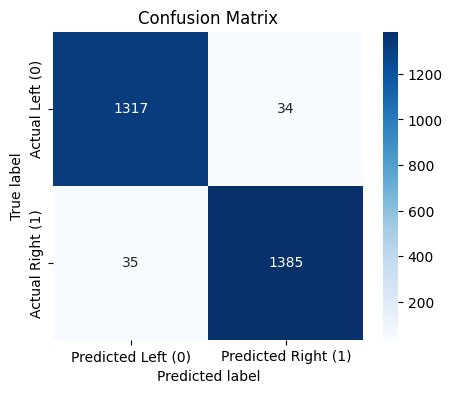

In [10]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Left (0)", "Predicted Right (1)"],
            yticklabels=["Actual Left (0)", "Actual Right (1)"])
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()


In [11]:
# === Part 2: BM25 Relevance Scoring ===

# Define a simple preprocessing function to remove punctuation and lowercase the text
def preprocess(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text.split()

# Build the BM25 corpus: tokenize each document in df_combined
corpus = [preprocess(doc) for doc in df_combined['text']]
bm25 = BM25Okapi(corpus)

query = "healthcare for all citizens"
query_tokens = preprocess(query)

# Calculate BM25 relevance scores for each document in the corpus
relevance_scores = bm25.get_scores(query_tokens)

In [12]:
# === Part 3: Combine Bias Confidence Scores and BM25 Scores for Ranking ===

X_full = vectorizer.transform(df_combined['text'])

predicted_probs = lr_model.predict_proba(X_full)[:, 1]

bias_scores = 2 * predicted_probs - 1

relevance_scores = np.array(relevance_scores)

final_scores = relevance_scores * bias_scores

ranked_indices = np.argsort(final_scores)[::-1]

# Display the top 10 ranked documents
print("\nTop 10 Ranked Documents:")
for i, idx in enumerate(ranked_indices[:10], start=1):
    doc_text = df_combined.iloc[idx]['text'][:100].replace('\n', ' ')  # show first 100 characters
    print(f"{i}. Score: {final_scores[idx]:.4f} | Excerpt: {doc_text}...")


Top 10 Ranked Documents:
1. Score: 8.2616 | Excerpt: Citizens should be responsible for their own healthcare costs....
2. Score: 8.2029 | Excerpt: Lowering taxes for all promotes economic growth, incentivizes investment, and benefits all citizens....
3. Score: 7.7871 | Excerpt: Lower taxes for everyone stimulate economic growth and benefit all citizens...
4. Score: 7.2499 | Excerpt: Free-market competition leads to innovation and affordable healthcare options for all....
5. Score: 7.0311 | Excerpt: Lowering taxes for the wealthy stimulates economic growth and benefits all citizens....
6. Score: 6.8829 | Excerpt: Free market competition leads to innovation and improves healthcare outcomes for all....
7. Score: 6.6787 | Excerpt: Lower taxes encourage economic growth and individual prosperity, benefiting all citizens....
8. Score: 6.6668 | Excerpt: Lower taxes for the wealthy incentivize investment, job creation, and economic growth that benefits ...
9. Score: 6.5514 | Excerpt: Tax cuts 

In [13]:
def average_precision_at_k(relevance_scores, k):
    """Compute Average Precision at K for one query."""
    relevance_scores = np.array(relevance_scores)[:k]
    num_relevant = np.sum(relevance_scores)
    if num_relevant == 0:
        return 0.0
    cumulative_precision = [
        np.sum(relevance_scores[:i+1]) / (i+1) for i in range(len(relevance_scores))
    ]
    return np.sum(cumulative_precision * relevance_scores) / num_relevant

def mean_average_precision(relevance_scores_list, k=10):
    """Compute Mean Average Precision over multiple queries."""
    return np.mean([average_precision_at_k(scores, k) for scores in relevance_scores_list])

def dcg_at_k(relevance_scores, k):
    """Compute Discounted Cumulative Gain at K."""
    relevance_scores = np.array(relevance_scores)[:k]
    return np.sum(relevance_scores / np.log2(np.arange(2, len(relevance_scores) + 2)))

def ndcg_at_k(relevance_scores, k):
    """Compute Normalized Discounted Cumulative Gain at K."""
    ideal_relevance = sorted(relevance_scores, reverse=True)  # highest scores first
    return dcg_at_k(relevance_scores, k) / (dcg_at_k(ideal_relevance, k) + 1e-10)


# === Sample Evaluation ===
sample_queries = [
    "healthcare for all citizens",
    "tax cuts for economic growth",
    "environmental policy and climate change"
]

def get_final_scores(query, combination_strategy='multiplicative', alpha=0.5, beta=0.5):
    """
    Compute final ranking scores for the entire corpus given a query.

    Parameters:
    - query: str, the search query.
    - combination_strategy: string, one of 'multiplicative', 'additive', or 'weighted'.
    - alpha, beta: weights for the weighted sum combination.

    Returns:
    - final_scores: NumPy array of combined scores for each document.
    """
    query_tokens = preprocess(query)
    bm25_scores = np.array(bm25.get_scores(query_tokens))

    X_full = vectorizer.transform(df_combined['text'])
    predicted_probs = lr_model.predict_proba(X_full)[:, 1]
    bias_scores = 2 * predicted_probs - 1

    if combination_strategy == 'multiplicative':
        final_scores = bm25_scores * bias_scores
    elif combination_strategy == 'additive':
        final_scores = bm25_scores + bias_scores
    elif combination_strategy == 'weighted':
        final_scores = alpha * bm25_scores + beta * bias_scores
    else:
        raise ValueError("Invalid combination strategy provided.")

    return final_scores


dummy_judgments = {
    "healthcare for all citizens": [1 if i % 5 == 0 else 0 for i in range(len(df_combined))],
    "tax cuts for economic growth": [1 if i % 7 == 0 else 0 for i in range(len(df_combined))],
    "environmental policy and climate change": [1 if i % 11 == 0 else 0 for i in range(len(df_combined))]
}

map_scores = []
ndcg_scores = []
k = 10

for query in sample_queries:
    final_scores = get_final_scores(query, combination_strategy='multiplicative')
    ranked_indices = np.argsort(final_scores)[::-1]

    # Generate the relevance list for the ranked order
    ranked_relevances = [dummy_judgments[query][idx] for idx in ranked_indices]

    ap = average_precision_at_k(ranked_relevances, k)
    ndcg = ndcg_at_k(ranked_relevances, k)
    map_scores.append(ap)
    ndcg_scores.append(ndcg)

    print(f"Query: '{query}'")
    print(f"MAP@{k}: {ap:.4f}, NDCG@{k}: {ndcg:.4f}\n")

print(f"Mean MAP@{k}: {np.mean(map_scores):.4f}")
print(f"Mean NDCG@{k}: {np.mean(ndcg_scores):.4f}")


Query: 'healthcare for all citizens'
MAP@10: 0.4557, NDCG@10: 0.4526

Query: 'tax cuts for economic growth'
MAP@10: 0.2786, NDCG@10: 0.2318

Query: 'environmental policy and climate change'
MAP@10: 0.1556, NDCG@10: 0.1299

Mean MAP@10: 0.2966
Mean NDCG@10: 0.2714


In [14]:
# Define a pipeline that first vectorizes and then applies logistic regression.
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True, stop_words='english')),
    ('lr', LogisticRegression(max_iter=200))
])

param_grid = {
    'tfidf__max_features': [None, 5000, 10000],
    'lr__C': [0.1, 1, 10],
    'lr__solver': ['lbfgs', 'liblinear']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_df_lr['text'], train_df_lr['binary_label'])

print("Best parameters found:")
print(grid_search.best_params_)
print("Best training accuracy:")
print(grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred_gs = best_model.predict(val_df_lr['text'])
print("Classification Report for Best Model:")
print(classification_report(val_df_lr['binary_label'], y_pred_gs))


Best parameters found:
{'lr__C': 10, 'lr__solver': 'liblinear', 'tfidf__max_features': None}
Best training accuracy:
0.9801114719916596
Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1351
           1       0.98      0.98      0.98      1420

    accuracy                           0.98      2771
   macro avg       0.98      0.98      0.98      2771
weighted avg       0.98      0.98      0.98      2771



In [15]:
# Example: Use weighted sum combination with alpha=0.6 (BM25 weight) and beta=0.4 (bias weight)
final_scores_weighted = get_final_scores("healthcare for all citizens", combination_strategy='weighted', alpha=0.6, beta=0.4)
ranked_indices_weighted = np.argsort(final_scores_weighted)[::-1]

print("\nTop 10 Ranked Documents using Weighted Sum Combination:")
for i, idx in enumerate(ranked_indices_weighted[:10], start=1):
    doc_text = df_combined.iloc[idx]['text'][:100].replace('\n', ' ')
    print(f"{i}. Score: {final_scores_weighted[idx]:.4f} | Excerpt: {doc_text}...")



Top 10 Ranked Documents using Weighted Sum Combination:
1. Score: 7.5666 | Excerpt: Universal healthcare guarantees access to healthcare for all citizens....
2. Score: 7.5413 | Excerpt: Government-funded healthcare ensures access to healthcare for all citizens....
3. Score: 7.4323 | Excerpt: Government-funded healthcare leads to better healthcare outcomes for all citizens....
4. Score: 7.4241 | Excerpt: Universal healthcare leads to better healthcare outcomes for all citizens....
5. Score: 7.2850 | Excerpt: Universal healthcare ensures access to quality healthcare for all citizens....
6. Score: 7.2850 | Excerpt: Universal healthcare ensures access to quality healthcare for all citizens....
7. Score: 7.1981 | Excerpt: We should have universal healthcare for all citizens....
8. Score: 7.1484 | Excerpt: We should provide free healthcare for all citizens....
9. Score: 7.1484 | Excerpt: We should provide free healthcare for all citizens....
10. Score: 7.1459 | Excerpt: Universal healthcare

In [16]:
def analyze_query(query, combination_strategy):
    query_tokens = preprocess(query)
    bm25_scores = np.array(bm25.get_scores(query_tokens))

    X_full = vectorizer.transform(df_combined['text'])
    predicted_probs = lr_model.predict_proba(X_full)[:, 1]
    bias_scores = 2 * predicted_probs - 1

    if combination_strategy == 'multiplicative':
        final_scores = bm25_scores * bias_scores
    elif combination_strategy == 'additive':
        final_scores = bm25_scores + bias_scores
    elif combination_strategy == 'weighted':
        final_scores = 0.6 * bm25_scores + 0.4 * bias_scores
    else:
        raise ValueError("Invalid combination strategy.")

    ranked_indices = np.argsort(final_scores)[::-1]
    print(f"\nAnalysis for Query: '{query}'")
    print("{:<4} {:<10} {:<10} {:<10} {:<}".format("Rank", "BM25", "Bias", "Final", "Text Excerpt"))
    for i, idx in enumerate(ranked_indices[:10], start=1):
        bm25_sc = bm25_scores[idx]
        bias_sc = bias_scores[idx]
        final_sc = final_scores[idx]
        text_excerpt = df_combined.iloc[idx]['text'][:80].replace('\n', ' ')
        print(f"{i:<4} {bm25_sc:<10.4f} {bias_sc:<10.4f} {final_sc:<10.4f} {text_excerpt}")

analyze_query("tax cuts for economic growth", combination_strategy='weighted')



Analysis for Query: 'tax cuts for economic growth'
Rank BM25       Bias       Final      Text Excerpt
1    20.0596    0.6638     12.3013    Tax cuts for the wealthy stimulate economic growth.
2    17.9310    0.7227     11.0477    Tax cuts for the wealthy stimulate economic growth and benefit everyone.
3    17.9310    0.7227     11.0477    Tax cuts for the wealthy stimulate economic growth and benefit everyone.
4    17.9310    0.7227     11.0477    Tax cuts for the wealthy stimulate economic growth and benefit everyone
5    17.9310    0.7214     11.0472    Tax cuts for the wealthy stimulate economic growth and incentivize investment.
6    17.3185    0.8739     10.7407    Tax cuts for the wealthy encourage investment, job creation, and economic growth
7    17.3185    0.8258     10.7214    Tax cuts for the wealthy stimulate economic growth and incentivize job creation.
8    16.7464    0.6330     10.3010    Tax cuts for the wealthy stimulate economic growth and benefit all income levels
9

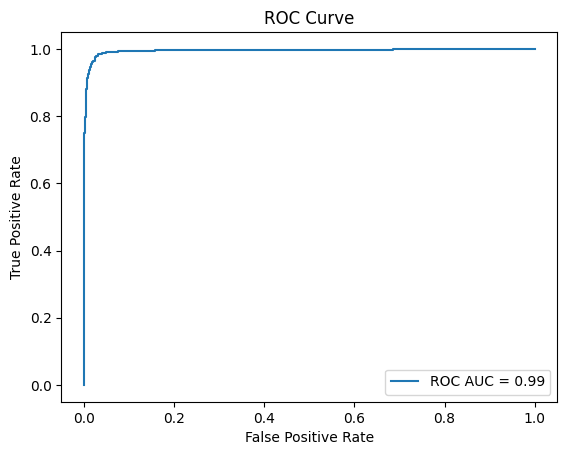

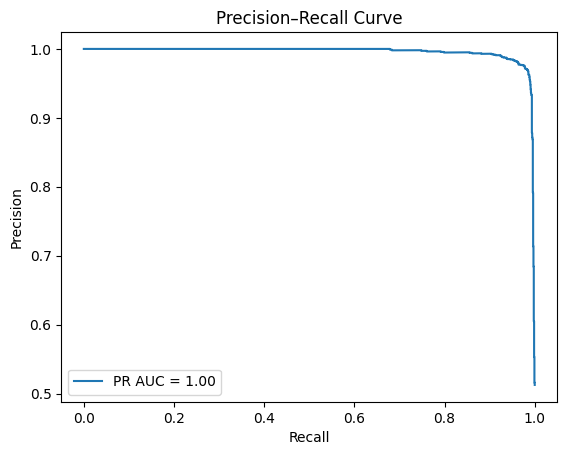

In [22]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
y_proba = lr_model.predict_proba(X_val)[:, 1]


fpr, tpr, _ = roc_curve(y_val, y_proba)
prec, rec, _ = precision_recall_curve(y_val, y_proba)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {auc(fpr, tpr):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Precision–Recall
plt.figure()
plt.plot(rec, prec, label=f"PR AUC = {auc(rec, prec):.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.show()


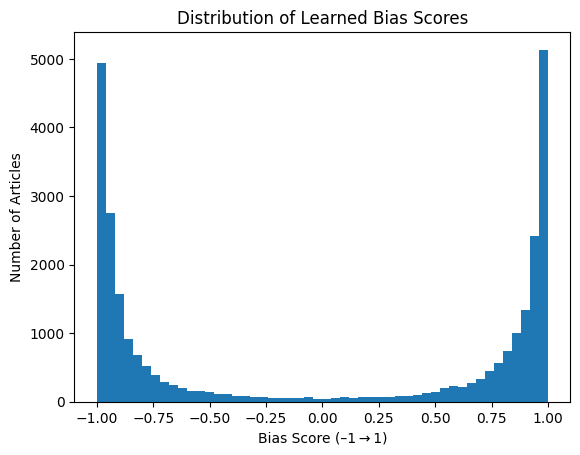

In [18]:
plt.figure()
plt.hist(bias_scores, bins=50)
plt.xlabel("Bias Score (–1 → 1)")
plt.ylabel("Number of Articles")
plt.title("Distribution of Learned Bias Scores")
plt.show()


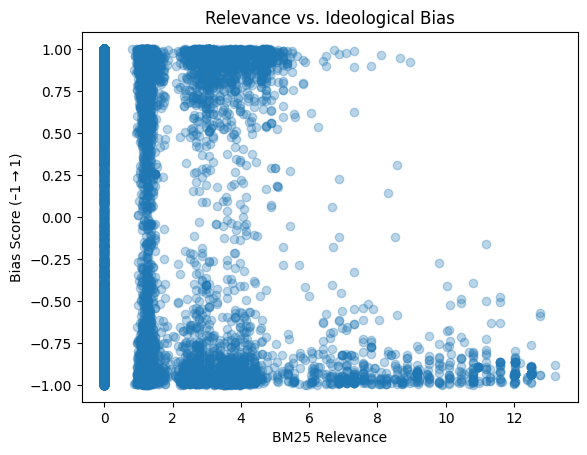

In [19]:
plt.figure()
plt.scatter(relevance_scores, bias_scores, alpha=0.3)
plt.xlabel("BM25 Relevance")
plt.ylabel("Bias Score (–1 → 1)")
plt.title("Relevance vs. Ideological Bias")
plt.show()


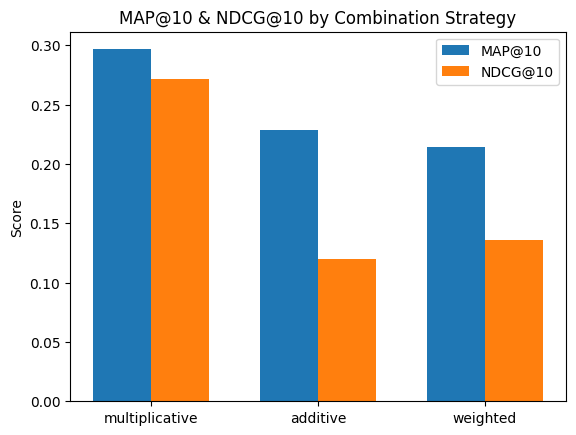

In [23]:
strategies = ["multiplicative", "additive", "weighted"]
map_scores, ndcg_scores = [], []
k = 10

for strat in strategies:
    per_query_maps, per_query_ndcgs = [], []
    for q in sample_queries:
        final_scores = get_final_scores(q,
                                        combination_strategy=strat,
                                        alpha=0.6,
                                        beta=0.4)
        ranked = np.argsort(final_scores)[::-1]
        relevances = [dummy_judgments[q][i] for i in ranked]
        per_query_maps.append(average_precision_at_k(relevances, k))
        per_query_ndcgs.append(ndcg_at_k(relevances, k))

    map_scores.append(np.mean(per_query_maps))
    ndcg_scores.append(np.mean(per_query_ndcgs))

# Now plot
x = np.arange(len(strategies))
width = 0.35

plt.figure()
plt.bar(x - width/2, map_scores, width, label="MAP@10")
plt.bar(x + width/2, ndcg_scores, width, label="NDCG@10")
plt.xticks(x, strategies)
plt.ylabel("Score")
plt.title("MAP@10 & NDCG@10 by Combination Strategy")
plt.legend()
plt.show()


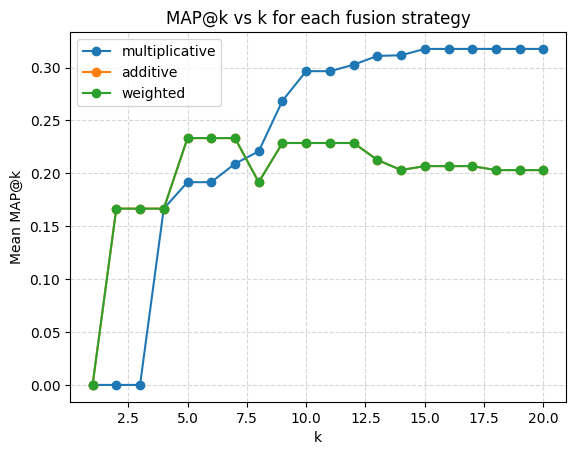

In [26]:
plt.figure()
for strat in ["multiplicative","additive","weighted"]:
    # rebuild a separate relevances_list for this strat...
    list_for_strat = []
    for q in sample_queries:
        s = get_final_scores(q, combination_strategy=strat)
        idxs = np.argsort(s)[::-1]
        list_for_strat.append([dummy_judgments[q][i] for i in idxs])

    map_scores = [np.mean([average_precision_at_k(rel, k) for rel in list_for_strat])
                  for k in ks]
    plt.plot(ks, map_scores, marker="o", label=strat)

plt.xlabel("k")
plt.ylabel("Mean MAP@k")
plt.title("MAP@k vs k for each fusion strategy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


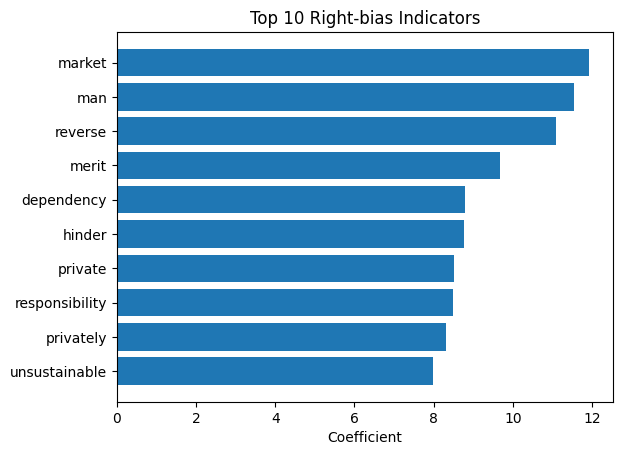

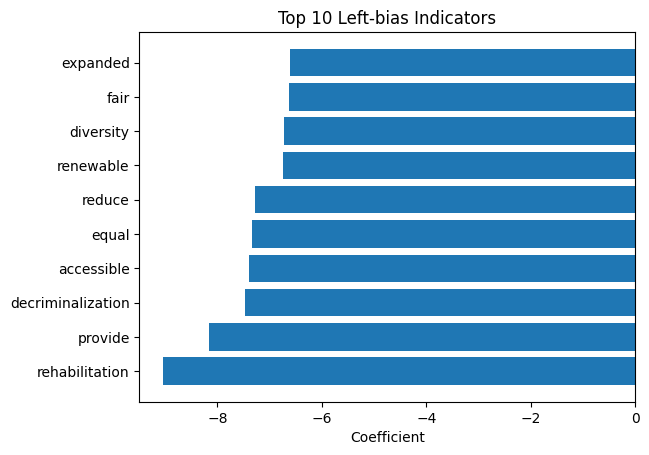

In [21]:
# After fitting GridSearchCV or direct LR:
feature_names = best_model.named_steps['tfidf'].get_feature_names_out()
coefs = best_model.named_steps['lr'].coef_[0]
top_pos = np.argsort(coefs)[-10:]
top_neg = np.argsort(coefs)[:10]

plt.figure()
plt.barh(feature_names[top_pos], coefs[top_pos])
plt.title("Top 10 Right-bias Indicators")
plt.xlabel("Coefficient")
plt.show()

plt.figure()
plt.barh(feature_names[top_neg], coefs[top_neg])
plt.title("Top 10 Left-bias Indicators")
plt.xlabel("Coefficient")
plt.show()
